# Modelo de Regressão Logística Binária

#### Imports das bibliotecas utilizadas

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score

import pickle

#### Carregamento do dataset

In [2]:
USE_ALL_DATA=False

df = pd.read_csv('../dados/amostra.sample.final.full.csv')
df['texto_clean_pure'].replace(' ', np.nan, inplace=True)
df.drop(df.columns.difference(['categoria_binaria','texto_clean_pure']), axis=1, inplace=True)
df.dropna(subset=['texto_clean_pure'], inplace=True)
if not USE_ALL_DATA:
    df = df.sample(n=7020*2, random_state=80)

print('Shape: {}'.format(df.shape))

Shape: (14040, 2)


In [ ]:
df.head()

#### Funções utilitárias

In [4]:
plt.rcParams.update({'font.size': 18})

def _matrix_confusao(y_test, y_hat, show_report=True, show_chart=True):
    if (show_report):
        print(classification_report(y_test, y_hat, digits=4, zero_division=0))

    if (show_chart):
        cm_rlb = confusion_matrix(y_test, y_hat)
        #plt.figure(figsize=(8, 6))
        plt.figure(figsize=(10, 8))
        #sns.set_context("poster",font_scale=.8)
        sns.heatmap(cm_rlb, annot=True, fmt='0.0f', linewidth=0.5, cmap='viridis_r',
            square=True, cbar=False)
        plt.ylabel("Classe Observada")
        plt.xlabel("Classe Prevista")
        plt.show()

def _curva_roc(y, p_hat):
    #Plot graph
    fpr, tpr, thr = roc_curve(y, p_hat)
    calculated_auc = auc(fpr, tpr)

    sns.set_palette("viridis")
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('1 - Especificidade (Taxa de Falsos Positivos)') # False Positive Rate = False Positives / (False Positives + True Negatives) <=> Specificity = True Negatives / (True Negatives + False Positives) <=> False Positive Rate = 1 - Specificity
    plt.ylabel('Sensibilidade (Taxa de Verdadeiros Positivos)') # True Positive Rate = True Positives / (True Positives + False Negatives) <=> Sensitivity = True Positives / (True Positives + False Negatives) <=> Recall
    plt.legend(["AUC {0:.4f}".format(calculated_auc)], loc="lower right")
    plt.show()

def _precision_recall(y_test, p_hat, y_hat):
    precision, recall, _ = precision_recall_curve(y_test, p_hat)
    f1, calculated_auc = f1_score(y_test, y_hat), auc(recall, precision)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.xlabel('Revocação')
    plt.ylabel('Precisão')
    plt.legend(["AUC {0:.4f}".format(calculated_auc)], loc="lower right")
    plt.show()

def _histograma(distribuition):
    plt.figure(figsize=(10, 8))
    plt.hist(distribuition, bins=50)
    plt.text(0.51, 410,'cutoff', rotation=90)
    plt.axvline(x=0.5, color='orange')
    plt.grid(axis='y', alpha=0.50)
    plt.xlabel('Probabilidade')
    plt.ylabel('Frequência')
    plt.show()


#### Criação do modelo

In [5]:
X = df['texto_clean_pure'].values.astype('U')
Y = df['categoria_binaria']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 80% treino
x_validation, x_test, y_validation, y_test,  = train_test_split(x_test, y_test, test_size=0.5, random_state=42) # 10% teste e 10% validação

print('Shapes de TRAIN - x_train={} e y_train={}'.format(np.shape(x_train), np.shape(y_train)))
print('Shapes de VALIDATION - x_validation={} e y_validation={}'.format(np.shape(x_validation), np.shape(y_validation)))
print('Shapes de TEST - x_test={} e y_test={}'.format(np.shape(x_test), np.shape(y_test)))

Shapes de TRAIN - x_train=(11232,) e y_train=(11232,)
Shapes de VALIDATION - x_validation=(1404,) e y_validation=(1404,)
Shapes de TEST - x_test=(1404,) e y_test=(1404,)


#### Cross Validation

In [7]:

# defining parameter range
param_grid = {
              'vect__max_df': [0.80, 0.85, 0.90, 0.95],
              'vect__max_features': [100, 1000, 10000],
              'clf__C' : [0.1, 1, 10, 100], 
              'clf__penalty': ['l1', 'l2'],
              }
n_folds = 5
n_jobs = 8

vectorize_tfidf = TfidfVectorizer(use_idf=False, lowercase=True) 
clf = LogisticRegression(random_state=42, solver='saga', multi_class='multinomial')

lr_pipeline = Pipeline([('vect', vectorize_tfidf), ('clf', clf)])
grid = RandomizedSearchCV(lr_pipeline, param_grid, cv=n_folds, random_state=42, refit=True, verbose=3, n_jobs=n_jobs, scoring='accuracy') 

grid.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.85, vect__max_features=10000;, score=0.896 total time=  51.1s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.85, vect__max_features=10000;, score=0.912 total time=  51.8s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=10000;, score=0.895 total time=  52.5s
[CV 5/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=10000;, score=0.901 total time=  52.9s
[CV 3/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=10000;, score=0.896 total time=  53.3s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.85, vect__max_features=10000;, score=0.895 total time=  54.9s
[CV 1/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=10000;, score=0.911 total time=  55.6s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=10000;, score=0.898 total time=  57.0s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=100, clf__penalty=l2, vect__max_df=0.95, vect__max_features=1000;, score=0.900 total time=   7.9s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.8, vect__max_features=1000;, score=0.893 total time=  14.1s
[CV 2/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.8, vect__max_features=1000;, score=0.896 total time=  14.1s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.8, vect__max_features=1000;, score=0.887 total time=  17.4s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.8, vect__max_features=1000;, score=0.895 total time=  15.8s
[CV 4/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.8, vect__max_features=1000;, score=0.893 total time=  17.0s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=100, clf__penalty=l2, vect__max_df=0.95, vect__max_features=1000;, score=0.889 total time=   6.3s
[CV 4/5] END clf__C=100, clf__penalty=l2, vect__max_df=0.95, vect__max_features=1000;, score=0.898 total time=   6.5s
[CV 2/5] END clf__C=100, clf__penalty=l2, vect__max_df=0.95, vect__max_features=1000;, score=0.901 total time=   8.8s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END clf__C=100, clf__penalty=l2, vect__max_df=0.95, vect__max_features=1000;, score=0.900 total time=   7.3s
[CV 1/5] END clf__C=1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=100;, score=0.895 total time=   6.8s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=100;, score=0.890 total time=   6.2s
[CV 2/5] END clf__C=1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=100;, score=0.891 total time=   7.9s
[CV 4/5] END clf__C=1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=100;, score=0.893 total time=   6.4s
[CV 5/5] END clf__C=1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=100;, score=0.893 total time=   8.4s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=10, clf__penalty=l2, vect__max_df=0.95, vect__max_features=100;, score=0.897 total time=   5.1s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=1000;, score=0.895 total time=  14.7s
[CV 2/5] END clf__C=10, clf__penalty=l2, vect__max_df=0.95, vect__max_features=100;, score=0.887 total time=   5.3s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=1000;, score=0.897 total time=  14.2s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=1000;, score=0.894 total time=  17.0s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=1000;, score=0.886 total time=  17.5s
[CV 4/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.9, vect__max_features=1000;, score=0.894 total time=  17.0s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END clf__C=10, clf__penalty=l2, vect__max_df=0.95, vect__max_features=100;, score=0.895 total time=   5.6s
[CV 3/5] END clf__C=10, clf__penalty=l2, vect__max_df=0.95, vect__max_features=100;, score=0.887 total time=   5.9s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=1, clf__penalty=l2, vect__max_df=0.9, vect__max_features=100;, score=0.895 total time=   5.8s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END clf__C=10, clf__penalty=l2, vect__max_df=0.95, vect__max_features=100;, score=0.891 total time=   7.9s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END clf__C=1, clf__penalty=l2, vect__max_df=0.9, vect__max_features=100;, score=0.888 total time=   7.1s
[CV 4/5] END clf__C=1, clf__penalty=l2, vect__max_df=0.9, vect__max_features=100;, score=0.894 total time=   5.6s
[CV 2/5] END clf__C=1, clf__penalty=l2, vect__max_df=0.9, vect__max_features=100;, score=0.888 total time=   7.9s
[CV 5/5] END clf__C=1, clf__penalty=l2, vect__max_df=0.9, vect__max_features=100;, score=0.891 total time=   5.9s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.85, vect__max_features=10000;, score=0.902 total time=  54.9s


/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.8, vect__max_features=100;, score=0.890 total time=   6.0s
[CV 4/5] END clf__C=100, clf__penalty=l1, vect__max_df=0.85, vect__max_features=10000;, score=0.897 total time=  57.6s
[CV 2/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.8, vect__max_features=100;, score=0.883 total time=   7.4s
[CV 1/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=1000;, score=0.887 total time=   6.0s
[CV 3/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.8, vect__max_features=100;, score=0.883 total time=   7.3s
[CV 4/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.8, vect__max_features=100;, score=0.884 total time=   7.0s
[CV 5/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.8, vect__max_features=100;, score=0.882 total time=   7.4s
[CV 2/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.95, vect__max_features=1000;, score=0.881 total time=   6.6s
[CV 3/5] END clf__C=0.1, clf__penalty=l1, vect__max_df=0.95, vect

/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/mandamus-classification/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(use_idf=False)),
                                             ('clf',
                                              LogisticRegression(multi_class='multinomial',
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_jobs=8,
                   param_distributions={'clf__C': [0.1, 1, 10, 100],
                                        'clf__penalty': ['l1', 'l2'],
                                        'vect__max_df': [0.8, 0.85, 0.9, 0.95],
                                        'vect__max_features': [100, 1000,
                                                               10000]},
                   random_state=42, scoring='accuracy', verbose=3)

#### Salvando e/recuperando o modelo em disco

In [8]:

# open a file, where you stored the pickled data
#output_model_path = "/media/well/HD-E1/wagner/estudo/MBA - Data Science e Analytics/0_TCC/dados/3.1-regressao-logistica-seguida-multinomial-model.pkl"

#pickle.dump(grid, open(output_model_path, 'wb'))

#grid = pickle.load(open(output_model_path, 'rb'))

In [9]:
print(grid.best_params_)
print(grid.cv_results_)
print(grid.cv_results_["mean_test_score"])
print(grid.cv_results_["std_test_score"])
print('Tamanho do vocabulário: {}'.format(grid.best_estimator_[0].vocabulary_.__len__()))

{'vect__max_features': 10000, 'vect__max_df': 0.85, 'clf__penalty': 'l1', 'clf__C': 100}
{'mean_fit_time': array([53.22367334, 53.20896463, 14.96229177,  6.62789855,  6.42398601,
       15.29454641,  5.32607269,  5.72738595,  6.17454319,  5.34178586]), 'std_fit_time': array([1.63548503, 2.24569642, 1.32846755, 0.81478681, 0.76687845,
       1.27496351, 0.92494738, 0.74463592, 0.57137423, 0.38418783]), 'mean_score_time': array([1.02047477, 0.85084372, 0.72294097, 0.72456393, 0.70679431,
       0.77399564, 0.6353663 , 0.72337265, 0.83735538, 0.56909809]), 'std_score_time': array([0.17685223, 0.1136312 , 0.11225906, 0.12402661, 0.08946016,
       0.15604737, 0.09538653, 0.15031092, 0.08790842, 0.08324402]), 'param_vect__max_features': masked_array(data=[10000, 10000, 1000, 1000, 100, 1000, 100, 100, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'p

#### Aplicação na base de testes

In [10]:
model = grid.best_estimator_

p_hat = model.predict_proba(x_test)[:, 1]
y_hat = [0 if probability < 0.5 else 1 for probability in p_hat]

#### Geração de estatísticas

              precision    recall  f1-score   support

           0     0.9441    0.9571    0.9505      1235
           1     0.6513    0.5858    0.6168       169

    accuracy                         0.9124      1404
   macro avg     0.7977    0.7714    0.7837      1404
weighted avg     0.9088    0.9124    0.9104      1404



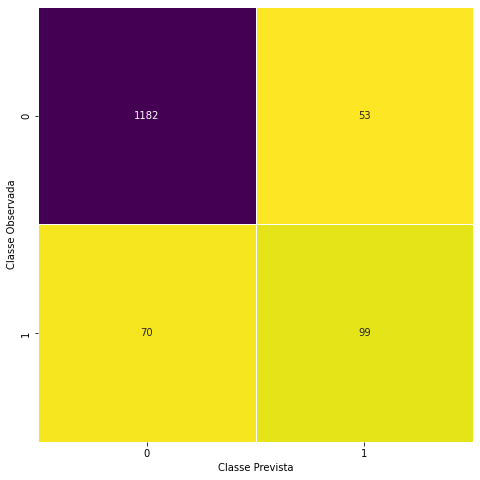

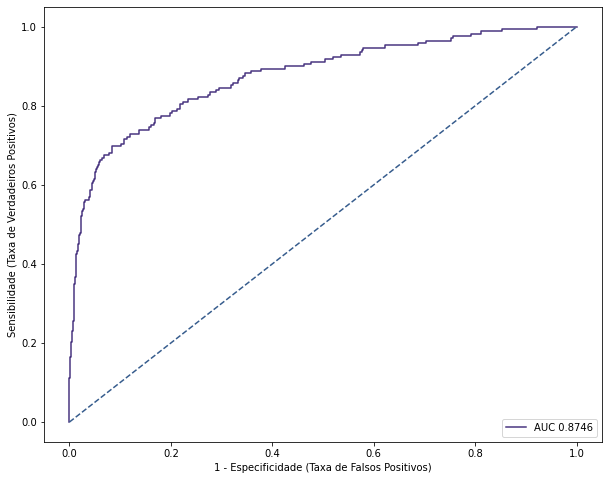

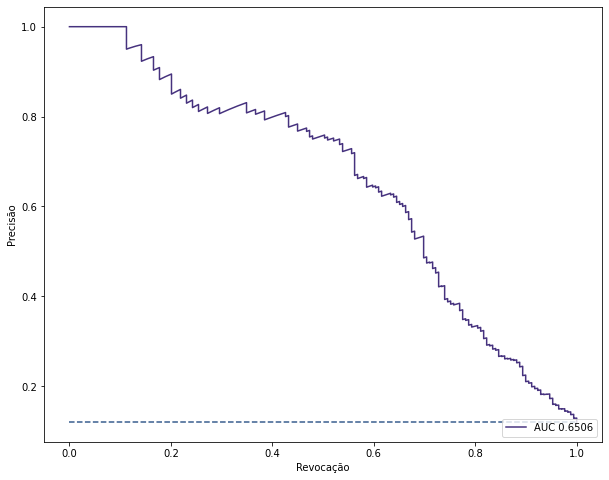

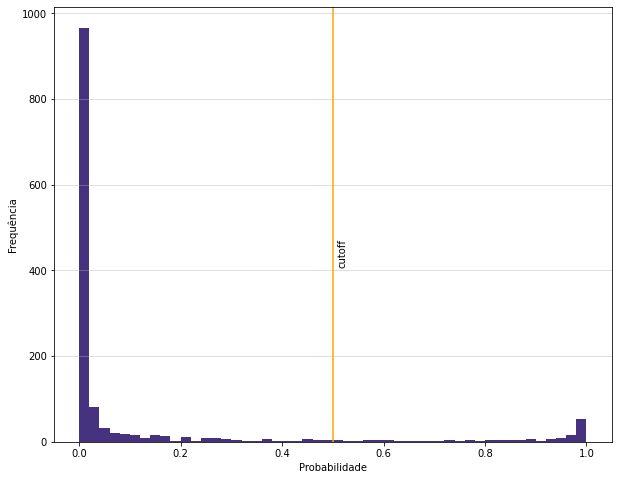

In [11]:
_matrix_confusao(y_test, y_hat)
_curva_roc(y_test, p_hat)
_precision_recall(y_test, p_hat, y_hat)
_histograma(p_hat)